# Setup

In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
df1 = pd.read_csv("Dataset1_TranscriptMahasiswa.csv", sep=";", dtype={"NIM" :"object", "NAMA_MK" : "string"})
df2 = pd.read_csv("Dataset2_EvaluasiDosenPerMK.csv", sep=";", decimal=",")

In [3]:
# Banyak Mahasiswa
df1["NIM"].nunique()

770

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30870 entries, 0 to 30869
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   NIM       30870 non-null  object 
 1   ANGKATAN  30870 non-null  int64  
 2   SEMESTER  30870 non-null  int64  
 3   KODE_MK   30870 non-null  object 
 4   NAMA_MK   30847 non-null  string 
 5   SKS       30870 non-null  int64  
 6   NILAI     30858 non-null  float64
 7   GRADE     30318 non-null  object 
dtypes: float64(1), int64(3), object(3), string(1)
memory usage: 1.9+ MB


Ada Nama_MK yang null, Nilai, dan Grade yang null

In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2114 entries, 0 to 2113
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TAHUN       2114 non-null   int64  
 1   SEMESTER    2114 non-null   int64  
 2   MATAKULIAH  2114 non-null   object 
 3   PERTANYAAN  2114 non-null   int64  
 4   KETERANGAN  2114 non-null   object 
 5   NILAI       2114 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 99.2+ KB


Tidak ada null

# Data Cleansing

**Dataframe 1 (Transkrip Mahasiswa)**

<AxesSubplot:>

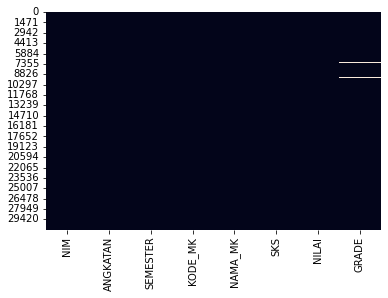

In [6]:
sns.heatmap(df1.isnull(), cbar=False)

In [7]:
# check Kode_MK dari Nama_MK yang null

df1['KODE_MK'][df1['NAMA_MK'].isnull()].unique()

array(['SI863'], dtype=object)

In [8]:
# fill Nama_MK yang null

df1["NAMA_MK"] = df1["NAMA_MK"].fillna("Tugas Akhir") # Kebetulan yang null cuman SI863

# add kode MK ke Nama_MK

for i in df1.index:  
    if df1.at[i, "KODE_MK"] not in df1.at[i, "NAMA_MK"].split(" ") : 
        df1.at[i, "NAMA_MK"] = df1.at[i, "KODE_MK"] + " " + df1.at[i, "NAMA_MK"]

In [9]:
indeks = ["A", "A-", "B+", "B", "B-", "C+", "C", "D", "E", "F"]
bobot = [4, 3.7, 3.3, 3.0, 2.7, 2.3, 2.0, 1.0, 0, 0]
ranges = [[100, 85], [84.99, 80], [79.99, 75], [74.99, 70], [69.99, 65], [64.99, 60], [59.99, 55], [54.99, 45], [44.99,0]]

# fill grade yang null

for i in df1.index:
    for j in ranges:
        if j[1] <= df1.at[i, "NILAI"] <= j[0]:
            df1.at[i, "GRADE"] = indeks[ranges.index(j)]

# menambah total bobot = bobot x sks

for i in df1.index:
    for j in indeks:
        if df1.at[i, "GRADE"] == j:
            df1.at[i, "BOBOT"] = bobot[indeks.index(j)]
            df1.at[i, "TOTAL_BOBOT"] = df1.at[i, "BOBOT"] * df1.at[i, "SKS"]

In [10]:
df1.head()

,NIM,ANGKATAN,SEMESTER,KODE_MK,NAMA_MK,SKS,NILAI,GRADE,BOBOT,TOTAL_BOBOT
0,10110310002,2010,1011,EM100,EM100 Dasar-dasar Bisnis,3,57.0,C,2.0,6.0
1,10110310002,2010,1011,EM180,EM180 Matematika Bisnis,3,70.0,B,3.0,9.0
2,10110310002,2010,1011,TI100,TI100 Algoritma dan Pemrograman,4,57.0,C,2.0,8.0
3,10110310002,2010,1011,TI101,TI101 Matematika Diskrit,3,59.0,C,2.0,6.0
4,10110310002,2010,1011,TI110,TI110 Pengantar Teknologi Multimedia,3,74.0,B,3.0,9.0


In [11]:
df1[df1['GRADE'].isnull()]

,NIM,ANGKATAN,SEMESTER,KODE_MK,NAMA_MK,SKS,NILAI,GRADE,BOBOT,TOTAL_BOBOT


In [12]:
df1[df1['NILAI'].isnull()]

,NIM,ANGKATAN,SEMESTER,KODE_MK,NAMA_MK,SKS,NILAI,GRADE,BOBOT,TOTAL_BOBOT
18866,00000009931,2015,1811,IS341,IS341 Sistem Basis Data,3,NaN,F,0.0,0.0
21965,00000012407,2015,1621,IS432,IS432 Pengantar E-Business,3,NaN,F,0.0,0.0
22633,00000013019,2016,1821,IS670,IS670 Audit Sistem Informasi,3,NaN,F,0.0,0.0
25920,00000019365,2017,1811,IS341,IS341 Sistem Basis Data,3,NaN,F,0.0,0.0
26030,00000019601,2017,1721,IS201,IS201 Proses Bisnis Korporat,3,NaN,F,0.0,0.0
26760,00000021116,2017,1711,IF110,IF110 Pengantar Teknologi Multimedia,3,NaN,F,0.0,0.0
26901,00000021159,2017,1821,UM321,UM321 Bahasa Inggris 3,2,NaN,F,0.0,0.0
27520,00000022742,2017,1721,IS230,IS230 Algoritma dan Pemrograman,3,NaN,F,0.0,0.0
27774,00000023564,2017,1721,IS230,IS230 Algoritma dan Pemrograman,3,NaN,F,0.0,0.0
29423,00000028446,2018,1821,IS220,IS220 Interaksi Manusia dan Komputer,3,NaN,F,0.0,0.0


Semua NILAI null berasal dari GRADE F

In [13]:
# fill null NILAI

df1["NILAI"] = df1["NILAI"].fillna(0)
df1[df1['NILAI'].isnull()]

,NIM,ANGKATAN,SEMESTER,KODE_MK,NAMA_MK,SKS,NILAI,GRADE,BOBOT,TOTAL_BOBOT


In [14]:
# check nim yang duplicate mk
def checkDuplicate():
    nim_mhs = df1['NIM'].unique()
    nim_for_doubled = []

    for nim in nim_mhs:
        dummy_df1 = df1.loc[df1['NIM'] == nim]
        if dummy_df1['NAMA_MK'].duplicated().any():
            nim_for_doubled.append(nim)
            
    return nim_for_doubled

In [15]:
checkDuplicate()

['10110310011',
 '10110310022',
 '10110310036',
 '10110310037',
 '10110310044',
 '10110310045',
 '10110310047',
 '10110310083',
 '11110310003',
 '11110310004',
 '11110310005',
 '11110310009',
 '11110310020',
 '11110310026',
 '11110310035',
 '11110310080',
 '13110310069']

In [16]:
print(f'Ada {len(checkDuplicate())} mahasiswa yang mengambil suatu mata kuliah secara berulang')

Ada 17 mahasiswa yang mengambil suatu mata kuliah secara berulang


In [17]:
# dropping duplicate MK
df1 = df1.drop_duplicates(subset=['KODE_MK', 'NIM'], keep='last')

In [18]:
print(f'Ada {len(checkDuplicate())} mahasiswa yang mengambil suatu mata kuliah secara berulang')

Ada 0 mahasiswa yang mengambil suatu mata kuliah secara berulang


In [19]:
df1

,NIM,ANGKATAN,SEMESTER,KODE_MK,NAMA_MK,SKS,NILAI,GRADE,BOBOT,TOTAL_BOBOT
0,10110310002,2010,1011,EM100,EM100 Dasar-dasar Bisnis,3,57.0,C,2.0,6.0
1,10110310002,2010,1011,EM180,EM180 Matematika Bisnis,3,70.0,B,3.0,9.0
2,10110310002,2010,1011,TI100,TI100 Algoritma dan Pemrograman,4,57.0,C,2.0,8.0
3,10110310002,2010,1011,TI101,TI101 Matematika Diskrit,3,59.0,C,2.0,6.0
4,10110310002,2010,1011,TI110,TI110 Pengantar Teknologi Multimedia,3,74.0,B,3.0,9.0
...,...,...,...,...,...,...,...,...,...,...
30865,00000033849,2018,1821,IS220,IS220 Interaksi Manusia dan Komputer,3,26.0,E,0.0,0.0
30866,00000033849,2018,1821,IS240,IS240 Probabilitas dan Statistik,3,38.0,E,0.0,0.0
30867,00000033849,2018,1821,IS251,IS251 Perilaku Organisasi,2,49.0,D,1.0,2.0
30868,00000033849,2018,1821,IS255,IS255 Algoritma dan Struktur Data,4,1.0,E,0.0,0.0


**Dataframe 2 (Evaluasi Dosen per Mata Kuliah)**

<AxesSubplot:>

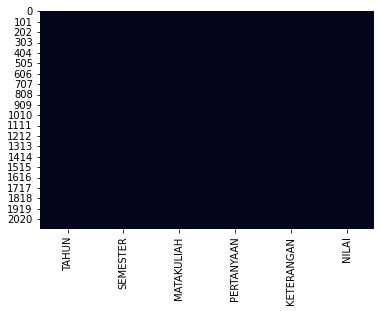

In [20]:
sns.heatmap(df2.isnull(), cbar=False)

In [21]:
df2.head(14)

,TAHUN,SEMESTER,MATAKULIAH,PERTANYAAN,KETERANGAN,NILAI
0,2015,1511,IS100 Management Information Systems,1,Kesiapan memberikan perkuliahan/praktikum,3.28
1,2015,1511,IS100 Management Information Systems,2,Upaya menyampaikan materi perkuliahan/praktik...,3.25
2,2015,1511,IS100 Management Information Systems,3,Sistematis dalam menyampaikan materi perkuliah...,3.24
3,2015,1511,IS100 Management Information Systems,4,Kemampuan memberikan contoh yang relevan dari ...,3.30
4,2015,1511,IS100 Management Information Systems,5,Penyampaian materi perkuliahan sesuai dengan k...,3.27
5,2015,1511,IS100 Management Information Systems,6,Pemakaian buku teks sebagai buku utama perkuli...,3.19
6,2015,1511,IS100 Management Information Systems,7,Memberi review materi perkuliahan sebelumnya,3.18
7,2015,1511,IS100 Management Information Systems,8,"Pemberian kesempatan bertanya, berdiskusi sert...",3.32
8,2015,1511,IS100 Management Information Systems,9,Kejelasan menjawab pertanyaan /diskusi di kelas,3.29
9,2015,1511,IS100 Management Information Systems,10,Pemberian tugas/kuis serta pembahasannya di kelas,3.24


In [22]:
# nilai rata-rata dari tiap matakuliah

df4 = pd.DataFrame(df2.groupby(["TAHUN", "MATAKULIAH"])["NILAI"].mean().reset_index())
df4.rename(columns = {"NILAI" : "NILAI_RATA-RATA"}, inplace = True)

df4

,TAHUN,MATAKULIAH,NILAI_RATA-RATA
0,2015,IS100 Management Information Systems,3.265000
1,2015,IS110 Business Mathematics,3.087143
2,2015,IS201 Corporate Business Processes,3.064286
3,2015,IS220 Human and Computer Interaction,3.295000
4,2015,IS230 Algorithms and Programming,3.129286
...,...,...,...
134,2018,IS726 Innovation in Information and Technology,3.363571
135,2018,IS747 Database Administration 2,3.740000
136,2018,IS749 Business Intelligence,3.361429
137,2018,IS773 IT Governance 3,3.240714


## Data Exploration

Text(0, 0.5, 'Jumlah')

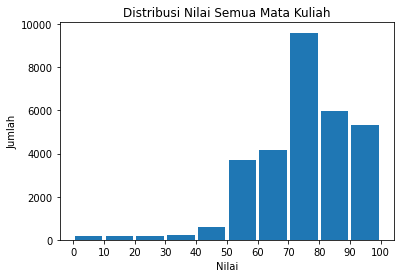

In [23]:
plt.title("Distribusi Nilai Semua Mata Kuliah")
plt.hist(df1["NILAI"], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], rwidth=0.9)
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.xlabel("Nilai")
plt.ylabel("Jumlah")

In [53]:
# Pembuataan Dataframe dengan grouping data berdasarkan NIM
# Perhitungan SKS
df3_ = pd.DataFrame(df1.groupby(["NIM"])["SKS"].sum().reset_index())
# Perhitungan Grade
df3__ = pd.DataFrame(df1.loc[(df1["GRADE"] == "D") | (df1["GRADE"] == "E") | (df1["GRADE"] == "F")].groupby("NIM")["GRADE"].sum().reset_index())
# Perhitungan Total Bobot
df3___ = pd.DataFrame((df1.groupby("NIM")["TOTAL_BOBOT"].sum().reset_index()))
# Perhitungan jumlah semester
df3____ =  pd.DataFrame((((df1.groupby("NIM")["SEMESTER"].max() - df1.groupby("NIM")["SEMESTER"].min()) / 100).reset_index()))

# Merging Dataframe
df3 = pd.merge(df3_, df3__, how="left", on=["NIM"])
df3 = pd.merge(df3, df3___, how="left", on=["NIM"])
df3 = pd.merge(df3, df3____, how="left", on=["NIM"])
df3["GRADE"] = df3["GRADE"].fillna("")

df3.rename(columns = {"GRADE" : "FAILED_GRADE", "SKS" : "TOTAL_SKS", "SEMESTER" : "WAKTU KULIAH"}, inplace = True)

# Perhitungan IPK
for i in df3.index:
    df3.at[i ,"IPK"] = df3.at[i, "TOTAL_BOBOT"] / df3.at[i, "TOTAL_SKS"]
    if df3.at[i, "WAKTU KULIAH"] - int(df3.at[i, "WAKTU KULIAH"]) != 0: 
        df3.at[i, "WAKTU KULIAH"] = int(df3.at[i, "WAKTU KULIAH"]) + 0.5
df3.head()

,NIM,TOTAL_SKS,FAILED_GRADE,TOTAL_BOBOT,WAKTU KULIAH,IPK
0,00000008429,145,D,474.5,3.5,3.272414
1,00000008455,136,DD,416.2,3.5,3.060294
2,00000008481,127,DDDEEED,313.6,3.5,2.469291
3,00000008631,145,,519.3,3.0,3.581379
4,00000008684,145,,512.1,3.0,3.531724


In [54]:
df3.loc[df3["NIM"] == '10110310022']

,NIM,TOTAL_SKS,FAILED_GRADE,TOTAL_BOBOT,WAKTU KULIAH,IPK
449,10110310022,145,DD,410.8,4.0,2.833103


In [55]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 770 entries, 0 to 769
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   NIM           770 non-null    object 
 1   TOTAL_SKS     770 non-null    int64  
 2   FAILED_GRADE  770 non-null    object 
 3   TOTAL_BOBOT   770 non-null    float64
 4   WAKTU KULIAH  770 non-null    float64
 5   IPK           770 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 62.1+ KB


In [56]:
# Belum Nambah Faktor yang ngulang terus nilainya udah lulus 
for i in df3.index:
    if df3.at[i, "TOTAL_SKS"] >= 144 and df3.at[i, "FAILED_GRADE"] == "" and df3.at[i, "IPK"] >= 2.5:
        df3.at[i, "TIDAK_LULUS"] = False
    else:  
        df3.at[i, "TIDAK_LULUS"] = True

In [57]:
df3['TIDAK_LULUS'] = df3['TIDAK_LULUS'].astype('bool')

In [58]:
df3['LULUS'] = ~df3['TIDAK_LULUS']

In [59]:
df3["TIDAK_LULUS"].value_counts()

True     589
False    181
Name: TIDAK_LULUS, dtype: int64

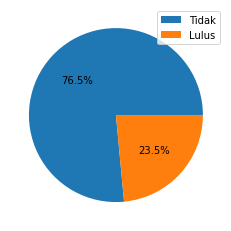

In [60]:
plt.pie(df3["TIDAK_LULUS"].value_counts(), autopct='%1.1f%%')
plt.legend(["Tidak", "Lulus"])

In [61]:
df3.loc[df3["LULUS"] == False]

,NIM,TOTAL_SKS,FAILED_GRADE,TOTAL_BOBOT,WAKTU KULIAH,IPK,TIDAK_LULUS,LULUS
0,00000008429,145,D,474.5,3.5,3.272414,True,False
1,00000008455,136,DD,416.2,3.5,3.060294,True,False
2,00000008481,127,DDDEEED,313.6,3.5,2.469291,True,False
5,00000008757,133,DEDDDD,399.0,3.5,3.000000,True,False
6,00000008775,145,D,506.5,3.5,3.493103,True,False
...,...,...,...,...,...,...,...,...
765,14110310095,145,DD,469.9,4.0,3.240690,True,False
766,14110310098,145,D,464.1,4.0,3.200690,True,False
767,14110310101,138,,438.4,4.5,3.176812,True,False
768,14110310102,133,EEE,362.2,4.5,2.723308,True,False


# Evaluating Models

In [45]:
np.random.seed(42)

In [50]:
# split dataset

X = df3[['TOTAL_SKS', 'IPK']]
y = df3['LULUS']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

In [51]:
# spot-check algorithm

models = [('LR', LogisticRegression()),
         ('CART', DecisionTreeClassifier()),
         ('RF', RandomForestClassifier())]

models_name = []
results = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    models_name.append(name)
    results.append(cv_score)
    print(f'{name} \t | cv_score_mean: {cv_score.mean()} \t | cv_score_std: {cv_score.std()}')

LR 	 | cv_score_mean: 0.8716575922565033 	 | cv_score_std: 0.035033191353950575
CART 	 | cv_score_mean: 0.8509679370840896 	 | cv_score_std: 0.03288367532759163
RF 	 | cv_score_mean: 0.8561101028433151 	 | cv_score_std: 0.02706854283915798


<AxesSubplot:>

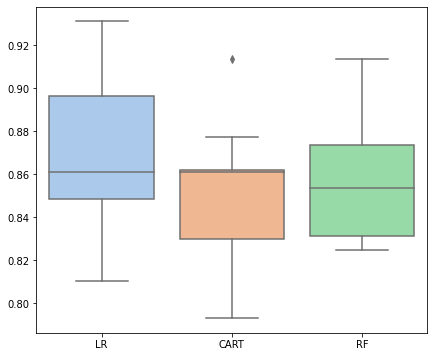

In [52]:
# boxplot comparing models

results_df = pd.DataFrame(np.asarray(results).T, columns=models_name)

plt.figure(figsize=(7,6))
sns.boxplot(data=results_df, palette='pastel')

# Train and Test the Model

In [ ]:
# train the model

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# prediction on validation set

y_preds = model.predict(X_val)

# evaluating accuracy

print('accuracy score', accuracy_score(y_val, y_preds)) 

accuracy score 0.8549222797927462


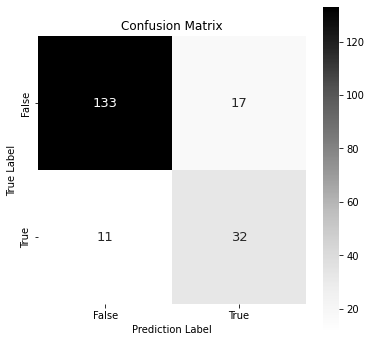

In [ ]:
# confusion matrix

conf_matrix = confusion_matrix(y_val, y_preds)

plt.figure(figsize=(6,6))

sns.heatmap(conf_matrix, annot=True, square=True, annot_kws={'fontsize': 13}, fmt='.3g',
           cmap = 'Greys', xticklabels=['False', 'True'], yticklabels=['False', 'True'])

plt.title('Confusion Matrix')
plt.xlabel('Prediction Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# classification report

print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

       False       0.92      0.89      0.90       150
        True       0.65      0.74      0.70        43

    accuracy                           0.85       193
   macro avg       0.79      0.82      0.80       193
weighted avg       0.86      0.85      0.86       193

